In [385]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Data preprocessing
The following block remove outliers, insignificant columns and correlated values from the initial file `local_global_res_13_12.csv`

In [386]:
data = pd.read_csv('./data/local_global_res_13_12.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36454 entries, 0 to 36453
Data columns (total 17 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Unnamed: 0.1   36454 non-null  int64  
 1   Unnamed: 0     36010 non-null  float64
 2   train_time     36280 non-null  float64
 3   forecast_time  36280 non-null  float64
 4   MAE            36280 non-null  float64
 5   MSE            36280 non-null  float64
 6   RMSE           36280 non-null  float64
 7   MASE           36280 non-null  float64
 8   RMSSE          36280 non-null  float64
 9   MAPE           36280 non-null  float64
 10  SMAPE          36280 non-null  float64
 11  naming_orig    36454 non-null  object 
 12  model_name     36454 non-null  object 
 13  dataset_name   36454 non-null  object 
 14  horizon        36454 non-null  int64  
 15  split          36454 non-null  object 
 16  pred_time      0 non-null      float64
dtypes: float64(11), int64(2), object(4)
memory usage: 

Let's look at the data and display the number of unique values for each column. If column contains numeric data, min and max values (excluding NaNs) are displayed also.

### Duplicates and irrelevant columns handling
First of all, we remove all the irrelevant data, duplicates nad artefacts from the dataset.

In [387]:
print(f'Duplicated rows:\n{data.duplicated()}\n')
print(f'Rows with NaN:\n{data.isna().sum()}\n')

Duplicated rows:
0        False
1        False
2        False
3        False
4        False
         ...  
36449    False
36450    False
36451    False
36452    False
36453    False
Length: 36454, dtype: bool

Rows with NaN:
Unnamed: 0.1         0
Unnamed: 0         444
train_time         174
forecast_time      174
MAE                174
MSE                174
RMSE               174
MASE               174
RMSSE              174
MAPE               174
SMAPE              174
naming_orig          0
model_name           0
dataset_name         0
horizon              0
split                0
pred_time        36454
dtype: int64



In [388]:
data

Unnamed: 0.1  Unnamed: 0  train_time  forecast_time        MAE   
0                 0         0.0    3.812914       4.442261  18.260277  \
1                 1         0.0    3.485261       4.376619  28.395468   
2                 2         0.0    3.812914       4.442261  12.825266   
3                 3         0.0    3.485261       4.376619  26.284388   
4                 4         0.0    3.485261       4.376619  15.145726   
...             ...         ...         ...            ...        ...   
36449             0         NaN  225.815618       1.806664   2.762839   
36450             0         NaN  221.914140       1.835336   2.712137   
36451             0         NaN  225.815618       1.806664   1.519503   
36452             0         NaN  221.914140       1.835336   3.380999   
36453             0         NaN  225.815618       1.806664   4.357973   

               MSE       RMSE      MASE     RMSSE       MAPE      SMAPE   
0       619.323792  24.886217  0.896638  0.792087        inf  16.386864  \
1      1160.189331  34.061552  1.088141  0.918072  41.157335  17.157184   
2       269.356567  16.412086  0.814535  0.757765  39.022604  13.038494   
3      1121.348877  33.486548  0.918232  0.792925  57.078475  18.962322   
4       429.357697  20.720948  0.663444  0.597604  21.996029  10.027625   
...            ...        ...       ...       ...        ...        ...   
36449    11.352131   3.369292  0.779592  0.688223  20.044580   8.785076   
36450    16.868277   4.107101  0.679580  0.778644  29.559124  10.474208   
36451     3.326512   1.823873  0.381234  0.345513  11.370875   5.622922   
36452    22.316181   4.724001  0.658609  0.684295  23.539458   8.428656   
36453    27.742617   5.267126  0.861970  0.773556  22.037254  10.565775   

               naming_orig                                   model_name   
0       danish_atm_daily_5  CatBoostAutoRegressivePipelineEtna_3lags_gl  \
1      danish_atm_daily_84  CatBoostAutoRegressivePipelineEtna_3lags_gl   
2      danish_atm_daily_32  CatBoostAutoRegressivePipelineEtna_3lags_gl   
3      danish_atm_daily_25  CatBoostAutoRegressivePipelineEtna_3lags_gl   
4       danish_atm_daily_6  CatBoostAutoRegressivePipelineEtna_3lags_gl   
...                    ...                                          ...   
36449               nn5_98                        DeepARTuningObjective   
36450               nn5_99                        DeepARTuningObjective   
36451               nn5_99                        DeepARTuningObjective   
36452                nn5_9                        DeepARTuningObjective   
36453                nn5_9                        DeepARTuningObjective   

           dataset_name  horizon       split  pred_time  
0      danish_atm_daily       30        test        NaN  
1      danish_atm_daily       30  validation        NaN  
2      danish_atm_daily       30        test        NaN  
3      danish_atm_daily       30  validation        NaN  
4      danish_atm_daily       30  validation        NaN  
...                 ...      ...         ...        ...  
36449               nn5       30  validation        NaN  
36450               nn5       30        test        NaN  
36451               nn5       30  validation        NaN  
36452               nn5       30        test        NaN  
36453               nn5       30  validation        NaN  

[36454 rows x 17 columns]

In [389]:
from pandas.api.types import is_numeric_dtype

sizes = pd.DataFrame(index=data.columns, columns=['unique_values', 'min', 'max'])

for col in data.columns:
    # For each column calculate number of unique values
    sizes.loc[col]['unique_values'] = len(data[col].unique())
    if is_numeric_dtype(data[col]):
        try:
            # If data type is numeric, try to calculate min and max values,
            # excluding NaNs
            sizes.loc[col]['min'] = np.min(data[col].dropna().unique())
            sizes.loc[col]['max'] = np.max(data[col].dropna().unique())
        except:
            # If column contains only NaNs, write NaN to both columns
            sizes.loc[col][['min', 'max']] = np.nan
    else:
        # If data type isn't numeric, write N/A - Not Applicable
        sizes.loc[col][['min', 'max']] = "N/A"

sizes

unique_values       min                 max
Unnamed: 0.1          36010         0               36009
Unnamed: 0                2       0.0                 0.0
train_time            18633   0.00006        28655.271598
forecast_time         17056  0.000003          189.939747
MAE                   29656  0.027207           8756287.0
MSE                   29666   0.00074   115030313926656.0
RMSE                  29666  0.027207     10725218.595752
MASE                  29711       0.0  26820764541.625977
RMSSE                 29715       0.0  26857884266.368134
MAPE                  23749  6.512892                 inf
SMAPE                 28441  3.166458               100.0
naming_orig             876       N/A                 N/A
model_name               24       N/A                 N/A
dataset_name              3       N/A                 N/A
horizon                   1        30                  30
split                     2       N/A                 N/A
pred_time                 1       NaN                 NaN

As we can see, the `pred_time`, `horizon`, `Unnamed: 0` and `Unnamed: 0.1` columns can be dropped. Two latter columns are artefacts from files concatenation. `horizon` column contains only single value, `dataset_name` is redundant due to the fact, that dataset_name is included into time series name. `pred_time` contains no valuable data.

In [390]:
data = data.drop(['pred_time', 'horizon', 'Unnamed: 0', 
                  'Unnamed: 0.1', 'dataset_name'], axis=1)
data = data.dropna()

### Outliers handling
Secondly, the outliers are removed. We decided, that outliers can be no more that 2.5% of the total data volume.

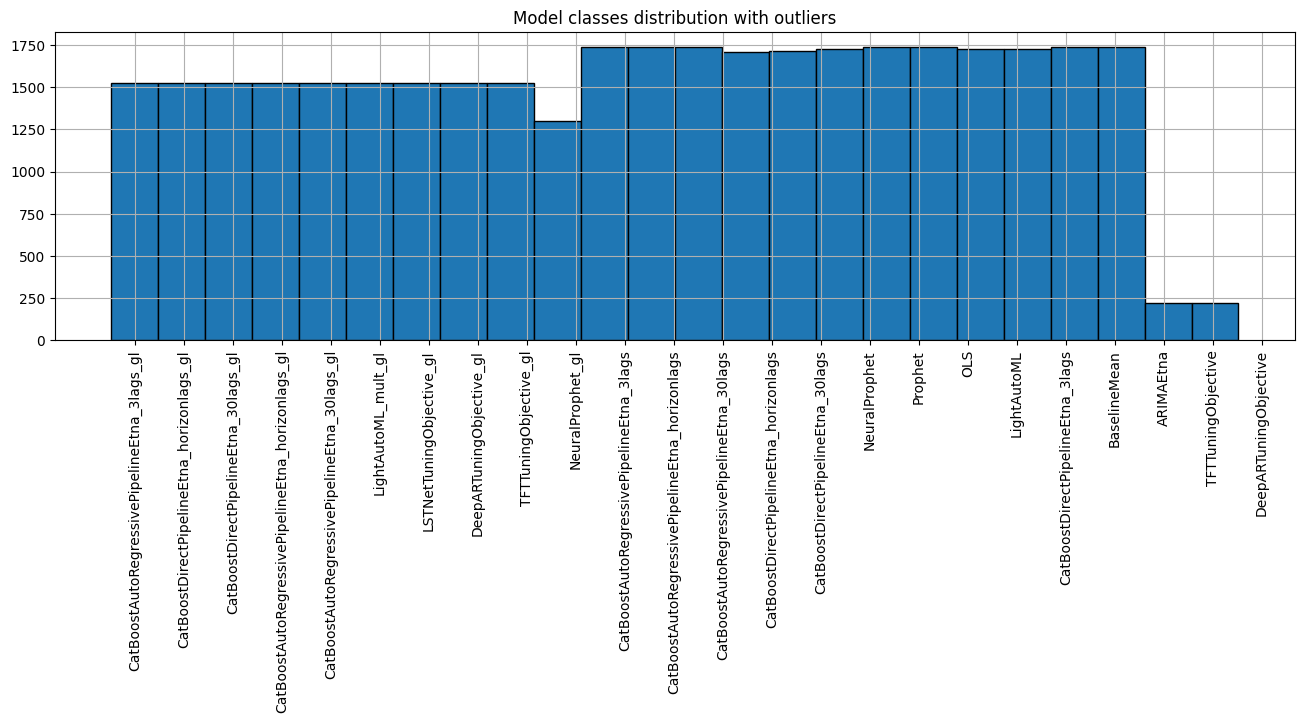

In [391]:
# Depict classes distribution histogram
fig = plt.figure(figsize=(16,4))
plt.hist(data['model_name'], bins=len(data['model_name'].unique()), 
         align='left', edgecolor='black')
plt.xticks(rotation=90); plt.grid()
plt.title('Model classes distribution with outliers')
plt.show()

Now, we will look at the remained numerical values to find anomalies using box plots.

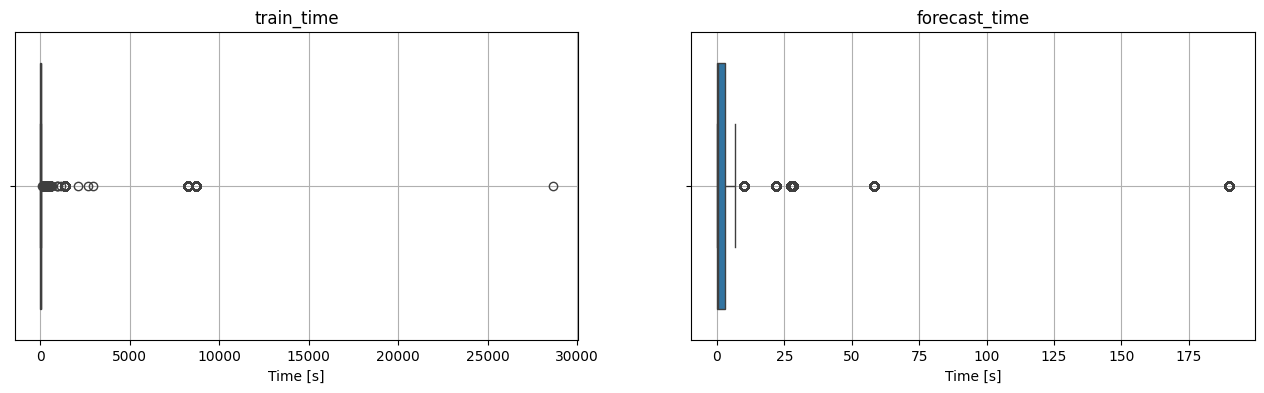

In [392]:
# Depict time metrics boxplots
times = ['train_time', 'forecast_time']
rows = 1

fig, axes = plt.subplots(nrows=rows, ncols=len(times)//rows, figsize=(16, 4))

for ax, time in zip(axes.flatten(), times):
    sns.boxplot(data[time], ax=ax, orient='h')
    ax.grid()
    ax.set_title(time)
    ax.set_xlabel('Time [s]')

plt.show()

We can see, that there is an outlier w.r.t. to the train time.

In [393]:
data[data['train_time'] > 10000]

train_time  forecast_time         MAE           MSE          RMSE   
27920  28655.271598       0.262712  850909.875  1.127550e+12  1.061862e+06  \

           MASE     RMSSE       MAPE      SMAPE    naming_orig   model_name   
27920  0.927062  0.873742  65.280634  17.660116  mipt_alpha_40  LightAutoML  \

            split  
27920  validation

In [394]:
data = data.drop(data[data['train_time'] > 10000].index)

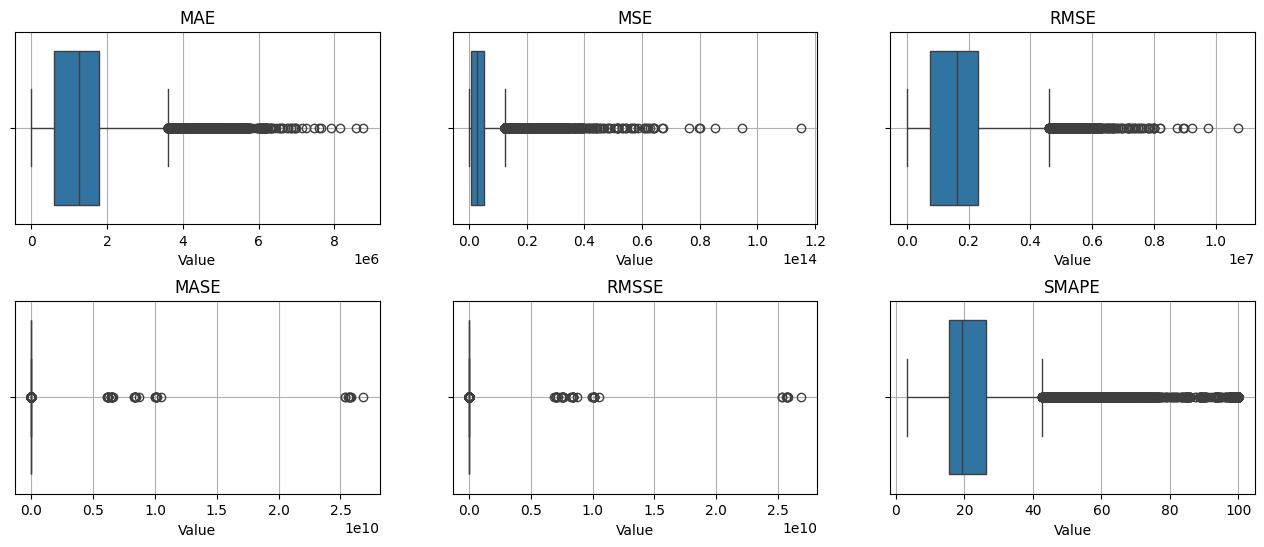

In [395]:
# Depict quality metrics boxplots
labels = data.select_dtypes(include=np.number).columns.tolist()
labels = [l for l in labels if l not in times]
labels.remove('MAPE')
rows = 2

fig, axes = plt.subplots(nrows=rows, ncols=len(labels)//rows, figsize=(16, 6))
fig.subplots_adjust(hspace=0.4)

for ax, label in zip(axes.flatten(), labels):
    sns.boxplot(data[label], ax=ax, orient='h')
    ax.grid()
    ax.set_title(label)
    ax.set_xlabel('Value')

plt.show()

We decided to ignore MAPE because of the metric unstability. As we can see, MAPE metrics become ill-contitioned whenever $y_i \in U(0)$, because
$$\text{MAPE}=100\% \times \frac{1}{n}\sum_{i=1}^{n}\frac{|y_i-\hat{y_i}|}{|y_i|},$$

where:

$y_i$ - time series i-th value;

$\hat{y_i}$ - predicted i-th value.

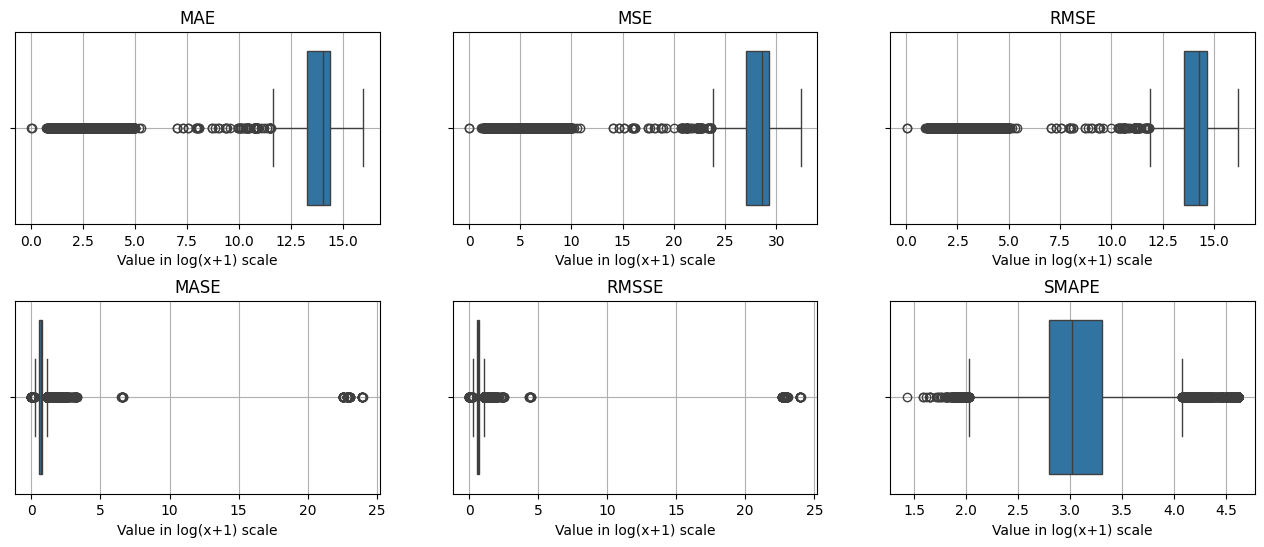

In [396]:
# Depict time metrics boxplots in log(1+x) scale
fig, axes = plt.subplots(nrows=rows, ncols=len(labels)//rows, figsize=(16, 6))
fig.subplots_adjust(hspace=0.4)

for ax, label in zip(axes.flatten(), labels):
    sns.boxplot(np.log1p(data[label]), ax=ax, orient='h')
    ax.grid()
    ax.set_title(f'{label}')
    ax.set_xlabel('Value in log(x+1) scale')

plt.show()

It is obvious, that MASE and RMSSE in the $\log(x+1)$ scale highlight outliers. We have tried several threshold for MASE, RMSSE and RMSE and decided to apply the following threshold

$$S=\lbrace y_i, X_i \rbrace_{i=1}^m: \forall X \in S \Rightarrow X_{\text{MASE}} \leq 6 \cap X_{\text{RMSSE}} \leq 4 \cap X_{\text{RMSE}} \leq 6\cdot10^6.$$

In [397]:
rmsse_th = np.exp(3) - 1
mase_th = np.exp(5) - 1

outliers = len(data[(data['MASE'] > mase_th) | (data['RMSSE'] > rmsse_th)])
print(f'Number of rows with MASE > {mase_th:.2f} or RMSSE > {rmsse_th:.2f}: {outliers}')
print(f'Outliers rate: {outliers/len(data):.2%}')

Number of rows with MASE > 147.41 or RMSSE > 19.09: 54
Outliers rate: 0.15%


In [398]:
data[(data['MASE'] > mase_th) | (data['RMSSE'] > rmsse_th)]

train_time  forecast_time        MAE         MSE       RMSE   
53      3.812914       4.442261   6.131524   56.617256   7.524444  \
75      3.812914       4.442261  12.818467  365.421326  19.115997   
78      3.485261       4.376619  10.501555  110.459610  10.509977   
142     3.812914       4.442261   6.620748   51.877560   7.202608   
162     3.485261       4.376619   8.725776   76.253593   8.732330   
188     3.485261       4.376619  26.820765  721.345947  26.857884   
247     4.154512       0.130089   8.290218   68.727699   8.290217   
277     4.301992       0.159918   6.455943   49.305920   7.021817   
326     4.301992       0.159918  12.770802  364.935699  19.103290   
358     4.154512       0.130089   9.959980   99.201164   9.959978   
359     4.154512       0.130089  25.364422  643.893005  25.375047   
451     4.301992       0.159918   6.168616   57.193203   7.562619   
494     4.522060       0.138170   6.455943   49.305920   7.021817   
505     4.343787       0.176111   8.290218   68.727699   8.290217   
510     4.343787       0.176111  25.364422  643.893005  25.375047   
537     4.343787       0.176111   9.959980   99.201164   9.959978   
597     4.522060       0.138170  12.770802  364.935699  19.103290   
644     4.522060       0.138170   6.168616   57.193203   7.562619   
681     4.563503       6.657062   6.223438   57.910233   7.609877   
712     4.290656       6.559531  25.723234  662.074036  25.730799   
723     4.563503       6.657062  13.178288  400.094299  20.002357   
734     4.563503       6.657062   6.487908   49.868118   7.061736   
738     4.290656       6.559531  10.093410  101.885536  10.093837   
749     4.290656       6.559531   8.397529   70.524071   8.397861   
906     4.478806       6.864699  10.093410  101.885536  10.093837   
970     4.478806       6.864699  25.723234  662.074036  25.730799   
993     4.792454       6.783154  13.178288  400.094299  20.002357   
1026    4.478806       6.864699   8.397529   70.524071   8.397861   
1099    4.792454       6.783154   6.487908   49.868118   7.061736   
1110    4.792454       6.783154   6.223438   57.910233   7.609877   
1162  422.131572       1.231760  25.593048  658.823486  25.667557   
1171  422.131572       1.231760  10.048263  101.733086  10.086282   
1304  464.373897       1.430709   6.114093   54.893147   7.408991   
1332  464.373897       1.430709  12.752709  312.913391  17.689358   
1334  422.131572       1.231760   8.361219   70.405128   8.390776   
1335  464.373897       1.430709   6.401220   46.808796   6.841695   
1369  186.062429       0.059749  12.665097  371.795013  19.281987   
1376  185.499076       0.061836  10.111112  102.234573  10.111111   
1443  185.499076       0.061836   8.411763   70.757797   8.411765   
1447  186.062429       0.059749   6.492157   49.865635   7.061560   
1477  185.499076       0.061836  25.770834  664.674744  25.781287   
1492  186.062429       0.059749   6.181482   57.379013   7.574894   
1598  242.513582       1.849175   6.508791   50.132137   7.080405   
1660  230.448185       1.806167  25.832836  667.870911  25.843199   
1699  242.513582       1.849175  13.006045  375.498413  19.377781   
1715  242.513582       1.849175   6.187772   57.496086   7.582617   
1736  230.448185       1.806167  10.135061  102.719971  10.135086   
1801  230.448185       1.806167   8.426980   71.014069   8.426985   
1830  521.573514       0.411674  25.770844  664.675110  25.781294   
1842  521.573514       0.411674  10.111115  102.234627  10.111114   
1857  525.849185       0.409907   6.181485   57.378983   7.574892   
1874  521.573514       0.411674   8.411768   70.757828   8.411767   
1948  525.849185       0.409907   6.492156   49.865540   7.061554   
2015  525.849185       0.409907  12.184648  290.020813  17.029997   

              MASE         RMSSE        MAPE       SMAPE   
53    6.131524e+09  7.524444e+09         inf   39.032561  \
75    7.135613e+02  8.234437e+01  157.107484   25.457659   
78    1.050156e+10  1.050998e+

As the number of outliers does not exceeds 1%, we can drop them out.

In [399]:
data = data.drop(data[(data['MASE'] > mase_th) | (data['RMSSE'] > rmsse_th)].index)

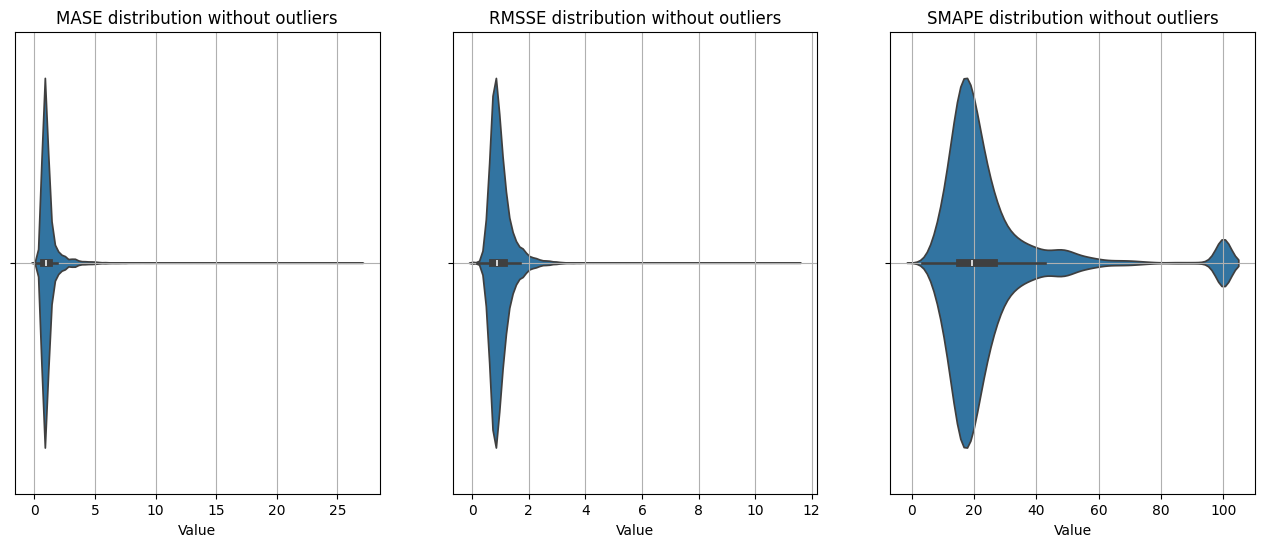

In [400]:
# Depict final metrics
labels = ['MASE', 'RMSSE', 'SMAPE']

fig, axes = plt.subplots(nrows=1, ncols=len(labels), figsize=(16, 6))
fig.subplots_adjust(hspace=0.4)

for ax, label in zip(axes.flatten(), labels):
    ax.set_xlabel('Value')
    sns.violinplot(data[label], ax=ax, orient='h')
    ax.grid()
    ax.set_title(f'{label} distribution without outliers')

plt.show()

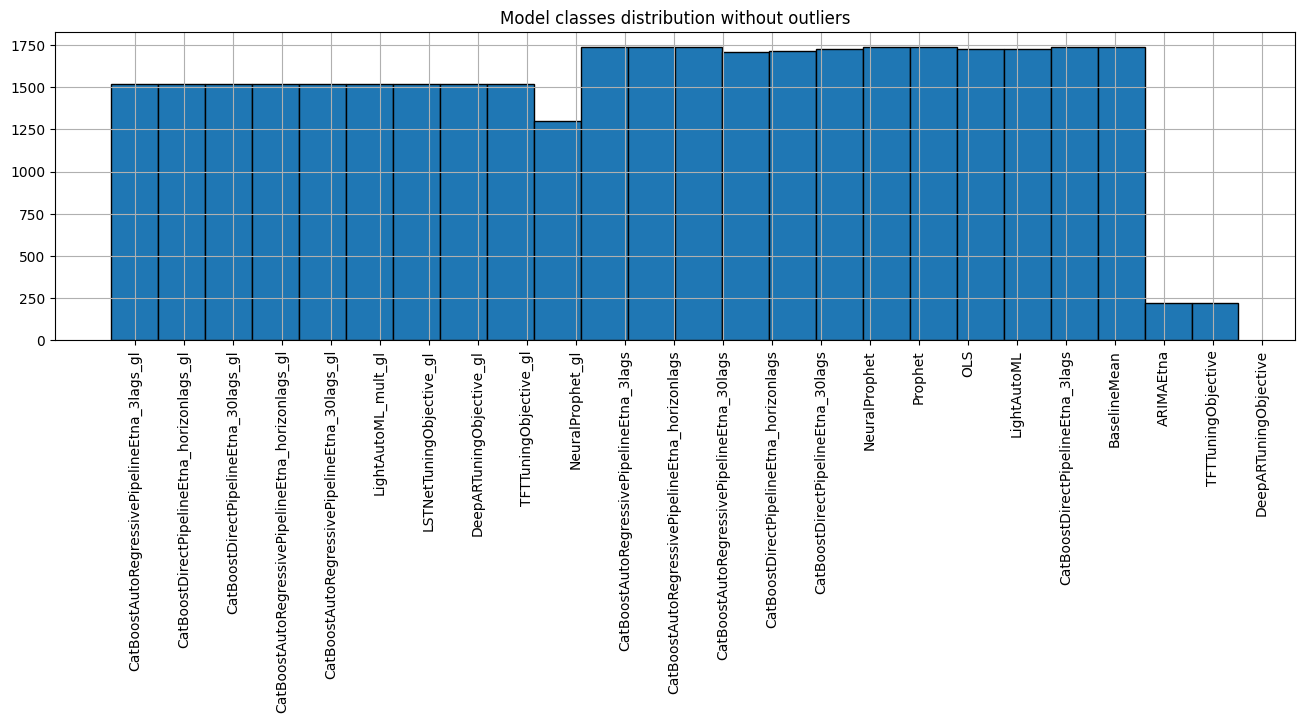

In [401]:
fig = plt.figure(figsize=(16,4))
plt.hist(data['model_name'], bins=len(data['model_name'].unique()), 
         align='left', edgecolor='black')
plt.xticks(rotation=90); plt.grid()
plt.title('Model classes distribution without outliers')
plt.show()

### Correlated values handling
Now, let's look at metrics correlation and drop out the correlated ones.

NB: all the correlation matrix below contains **absolute** correlation value, thus the sign of linear dependence is not accounted for. 

In [402]:
metrics = data.select_dtypes(include=np.number).columns.tolist()
np.abs(data[metrics].corr()).style.format("{:.2f}").background_gradient(cmap='Reds', high=1.01)

We must drop out MAE and MSE, which correlate to the RMSE. The same applies to MASE and MAPE.

In [403]:
data = data.drop(['MAE', 'MSE', 'MASE', 'MAPE'], axis=1)

In [404]:
metrics = data.select_dtypes(include=np.number).columns.tolist()
np.abs(data[metrics].corr()).style.format("{:.2f}").background_gradient(cmap='Reds', high=1.01)

We decided to introudce cumulative metric (CM), which can be calculated for the rule 'greater is better' as follows

$$CM=\frac{\sum_{i=1}^{n}\omega_i\exp(-x_i)}{\sum_{i=1}^{n}\omega_i};$$

for inverse condition the metric definition is a little different

$$CM=1-\frac{\sum_{i=1}^{n}\omega_i\exp(-x_i)}{\sum_{i=1}^{n}\omega_i},$$

where:

$x_i$ - metric;

$\omega_i$ - metric's weight.

The following metric both account for several quality metric and time performance. Another feature of this metric is the ability to handle outliers by itsel: if metric tends to the extremes, the meric value will still remain in the interval $CM\in[0,1]$ and preserve the realtive value of the corresponding metric (due to the monotonic property of the exponential function). Nevertheless, the metric has several limitations:

1. All the metrics must not cross the 0 value $|x_i| \geq 0, \forall i\in\mathbb{N}$;
2. All the metrics' absolute values must respresent quality in the same way: either "greater is better" or "lower is better";
3. The weights must be chosen properly to avoid the ill-condition.

In [405]:
def cumulative_metric(metrics, 
                      weights=np.ones((len(metrics), 1)), 
                      greater_is_better=False):
    
    # Assert metrics vectors sizes
    for metric in metrics:
        assert metrics[0].shape == metric.shape
    result = np.zeros(metrics[0].shape)
    # Add and normalize every metric with w*exp(-x)
    for metric, weight in zip(metrics, weights):
        result = result + weight*np.exp(-metric)
    # Normalize result w.r.t. metrics weight 
    result = result / np.sum(weights)
    # For inverse criteria
    if ~greater_is_better: result = 1 - result
        
    return result

In [406]:
weights = [0.15, 1, 1, 1]
data['CM'] = cumulative_metric([data['RMSE'], data['RMSSE'], data['SMAPE'], 
                                data['train_time']+data['forecast_time']],
                               weights, greater_is_better=False)

In [407]:
metrics = data.select_dtypes(include=np.number).columns.tolist()
np.abs(data[metrics].corr()).style.format("{:.2f}").background_gradient(cmap='Reds', high=1.01)

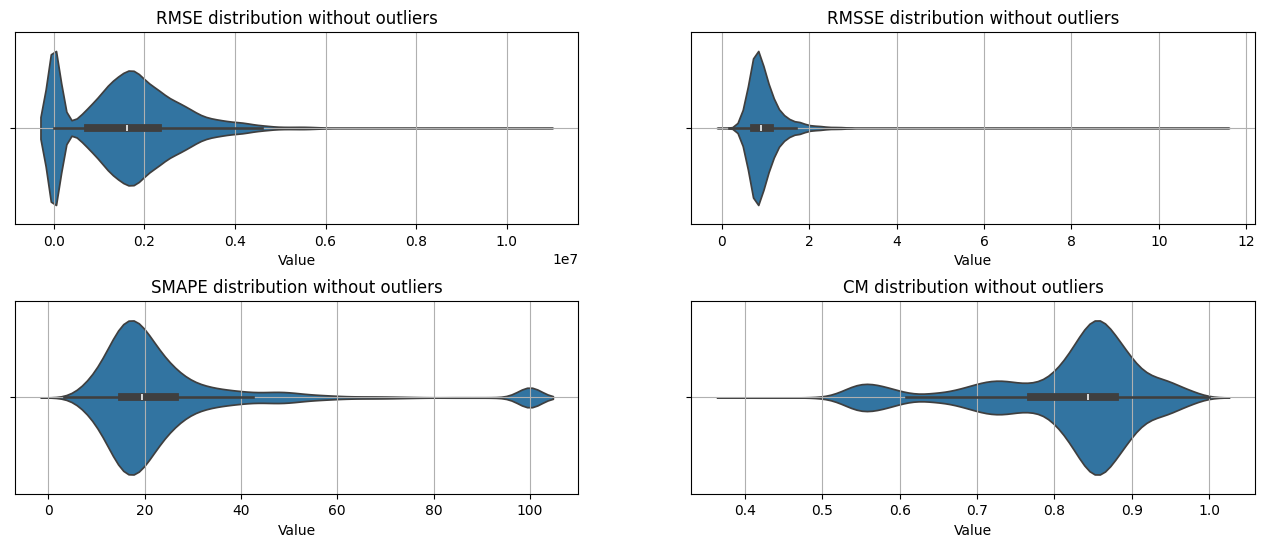

In [408]:
# Depicts final metrics distribution
labels = ['RMSE', 'RMSSE', 'SMAPE', 'CM']
rows = 2

fig, axes = plt.subplots(nrows=rows, ncols=len(labels)//rows, figsize=(16, 6))
fig.subplots_adjust(hspace=0.4)

for ax, label in zip(axes.flatten(), labels):
    ax.set_xlabel('Value')
    sns.violinplot(data[label], ax=ax, orient='h')
    ax.grid()
    ax.set_title(f'{label} distribution without outliers')
    

plt.show()
fig.savefig('./output/final_metrics', dpi=300)

In [409]:
data = data.sort_values(by=['naming_orig'])
data.to_csv('./data/full.csv')

### Dataset split
Prepare both training and test datasets. Fill them with the best method for every time series.

In [410]:
def best_method(input, index, label, criteria, na_handling=np.nan, 
                greater_is_better=False):

    '''
    Function which extracts best model from results table w.r.t. listed criteria

    Parameters
    ----------
    input : DataFrame,
        table with results
    index : str,
        column, from which data will be used as a row index
    label : str,
        column, which contains method name or label
    criteria : list,
        set of criteria, which will be used to find best method
    na_handling : np.number,
        value for handling the missed values
    greater_is_better : bool,
        setting to choose either greatest or lowest value from criteria

    Returns
    ----------
    best_results : DataFrame,
        table which rows contains unique values from 'index' column;
        there are len(criteria)+1 columns: 1st contains values from 'rows'
        column, other columns contain label with the best method w.r.t to
        stated criteria
    '''

    # Prepare rows columns for the table
    rows = input[index].unique()
    # Prepare columns for criteria values and model names
    suffs = ['', '-model']; cols = []
    for suff in suffs: 
        for criterion in criteria: 
            cols.append(criterion+suff)
    cols = np.concatenate(([index], cols))
    # Define dataframe
    best_results = pd.DataFrame(index=rows, columns=cols, data=na_handling)
    best_results[index] = rows

    # Iterate over timeseries and criteria
    for row in rows:
        batch = input[input[index]==row]
        for criterion in criteria:
            # If parameter is toggled True, find the greatest value.
            # Otherwise - the lowest one
            if greater_is_better:
                best_model = batch.iloc[batch[criterion].argmax()]
            else:
                best_model = batch.iloc[batch[criterion].argmin()]
            best_results.loc[row, criterion+suffs[0]] = best_model.loc[criterion]
            best_results.loc[row, criterion+suffs[1]] = best_model.loc[label]
            
    # Substitute temporary indexes with integers
    best_results.index = np.arange(len(rows))
    return best_results

In [411]:
# Extract training dataset from the initial table
train = data[data['split']=='validation']
train = train.drop(labels=['split'], axis=1)
# Create table with best methods for each time series
train = best_method(train, 'naming_orig', 'model_name', 
                    ['RMSE', 'RMSSE', 'SMAPE', 'CM'])
train = train.sort_values(by=['naming_orig'])
train

naming_orig       RMSE     RMSSE      SMAPE        CM   
0      danish_atm_daily_0  23.218063  0.427434   7.026373  0.524032  \
1      danish_atm_daily_1  38.754481  0.739715   7.451892  0.538878   
2     danish_atm_daily_10  15.445235  0.272509   7.352141  0.544331   
3    danish_atm_daily_100  14.839148  0.594626  11.260900  0.561100   
4    danish_atm_daily_101  37.519490  0.760683  14.842628  0.537497   
..                    ...        ...       ...        ...       ...   
866                nn5_95   4.530782  0.425082   6.984123  0.538589   
867                nn5_96   3.664217  0.422661  10.641290  0.513103   
868                nn5_97   3.081384  0.403758   7.315414  0.547920   
869                nn5_98   3.369292  0.534465   8.683399  0.579491   
870                nn5_99   1.823873  0.345513   5.622922  0.549676   

                                            RMSE-model   
0                                TFTTuningObjective_gl  \
1                                          LightAutoML   
2                                TFTTuningObjective_gl   
3    CatBoostAutoRegressivePipelineEtna_horizonlags_gl   
4                    CatBoostDirectPipelineEtna_30lags   
..                                                 ...   
866                                            Prophet   
867                                      NeuralProphet   
868          CatBoostAutoRegressivePipelineEtna_30lags   
869                              DeepARTuningObjective   
870                              DeepARTuningObjective   

                                           RMSSE-model   
0                                TFTTuningObjective_gl  \
1                                          LightAutoML   
2                                TFTTuningObjective_gl   
3    CatBoostAutoRegressivePipelineEtna_horizonlags_gl   
4                    CatBoostDirectPipelineEtna_30lags   
..                                                 ...   
866                                            Prophet   
867          CatBoostAutoRegressivePipelineEtna_30lags   
868                  CatBoostDirectPipelineEtna_30lags   
869          CatBoostAutoRegressivePipelineEtna_30lags   
870                              DeepARTuningObjective   

                           SMAPE-model      CM-model  
0                  LightAutoML_mult_gl           OLS  
1                          LightAutoML           OLS  
2                TFTTuningObjective_gl  BaselineMean  
3                TFTTuningObjective_gl  BaselineMean  
4    CatBoostDirectPipelineEtna_30lags  BaselineMean  
..                                 ...           ...  
866                      NeuralProphet           OLS  
867                      NeuralProphet  BaselineMean  
868              DeepARTuningObjective  BaselineMean  
869                        LightAutoML           OLS  
870              DeepARTuningObjective  BaselineMean  

[871 rows x 9 columns]

In [412]:
# Extract test dataset from the initial table
test = data[data['split']=='test']
test = test.drop(labels=['split'], axis=1)
# Create table with best methods for each time series
test = best_method(test, 'naming_orig', 'model_name', 
                    ['RMSE', 'RMSSE', 'SMAPE', 'CM'])
test = test.sort_values(by=['naming_orig'])
test

naming_orig       RMSE     RMSSE      SMAPE        CM   
0      danish_atm_daily_0  29.608086  0.558906  10.782377  0.558466  \
1      danish_atm_daily_1  46.476081  0.888003  11.191710  0.577808   
2     danish_atm_daily_10  14.278886  0.256301   7.867954  0.520321   
3    danish_atm_daily_100  22.717200  0.896521  23.149428  0.566854   
4    danish_atm_daily_101  25.814386  0.510870  16.457869  0.498319   
..                    ...        ...       ...        ...       ...   
866                nn5_95   4.262411  0.431838   9.664710  0.548938   
867                nn5_96   3.357216  0.464670  10.409026  0.523105   
868                nn5_97   6.029740  0.625903  14.901800  0.547768   
869                nn5_98   3.465682  0.452144   7.913091  0.572756   
870                nn5_99   3.457297  0.602815   9.885028  0.558984   

                                         RMSE-model   
0                             TFTTuningObjective_gl  \
1                  CatBoostDirectPipelineEtna_3lags   
2                             TFTTuningObjective_gl   
3                                           Prophet   
4                 CatBoostDirectPipelineEtna_30lags   
..                                              ...   
866        CatBoostAutoRegressivePipelineEtna_3lags   
867                                     LightAutoML   
868  CatBoostAutoRegressivePipelineEtna_horizonlags   
869       CatBoostAutoRegressivePipelineEtna_30lags   
870                                     LightAutoML   

                                   RMSSE-model   
0                        TFTTuningObjective_gl  \
1             CatBoostDirectPipelineEtna_3lags   
2                        TFTTuningObjective_gl   
3                     LSTNetTuningObjective_gl   
4            CatBoostDirectPipelineEtna_30lags   
..                                         ...   
866   CatBoostAutoRegressivePipelineEtna_3lags   
867                                LightAutoML   
868                                    Prophet   
869  CatBoostAutoRegressivePipelineEtna_30lags   
870                                LightAutoML   

                                     SMAPE-model      CM-model  
0                          TFTTuningObjective_gl  BaselineMean  
1                                    LightAutoML  BaselineMean  
2                          TFTTuningObjective_gl  BaselineMean  
3    CatBoostAutoRegressivePipelineEtna_3lags_gl  BaselineMean  
4              CatBoostDirectPipelineEtna_30lags  BaselineMean  
..                                           ...           ...  
866                        DeepARTuningObjective  BaselineMean  
867                                  LightAutoML           OLS  
868                           TFTTuningObjective           OLS  
869                           TFTTuningObjective           OLS  
870                                  LightAutoML  BaselineMean  

[871 rows x 9 columns]

In [413]:
# Assert set shapes equality 
assert train.shape == test.shape, f'Shapes are not equal: {train.shape} and {test.shape}'

In [414]:
test.to_csv('./data/full_test.csv')
train.to_csv('./data/full_train.csv')

## Straightforward solution
Let's assume, that the best method for each time series is the method with the highest number of best results.
The accuarcy we get from choosing that method for every time series and the MAE between true best error and this method error will be taken as a baseline.

In [415]:
def straightforward(raw_data, best_data, criteria, models):
    baseline = pd.DataFrame(index=criteria,
                            columns=['metric', 'model', 'accuracy', 'lost_rate', 'MAE'])
    assert np.array(models).shape == np.array(criteria).shape
    baseline['metric'] = criteria
    baseline['model'] = models

    total = len(best_data)
    for criterion, model in zip(criteria, models):
        # Calculate accuarcy
        tp = best_data[best_data[criterion+'-model']==model].count().iloc[0]
        
        # For remaining FP results caculate MAE w.r.t. designated criterion
        # Get all rows with the best model
        true_results = raw_data[raw_data['model_name']==model]
        n = 0; mae = 0; lost = 0; 
        # For each time series calculate discrepancy between best result and
        # predicted method
        for ts, result in zip(best_data['naming_orig'], best_data[criterion]):
            batch = true_results[true_results['naming_orig']==ts]
            try:
                true_value = batch.iloc[batch[criterion].argmin()][criterion]
                if true_value != result:
                    n = n + 1
                    mae = mae + np.abs(true_value - result)
            except:
                lost = lost + 1
            
        baseline.loc[criterion, 'MAE'] = mae / n
        baseline.loc[criterion, 'lost_rate'] = lost / total
        baseline.loc[criterion, 'accuracy'] = tp / total
        baseline.index = np.arange(len(criteria))
            
    return baseline

### Experiment I
We take the most frequent model from the **train** dataset and apply it to the whole **train** dataset as a prediction.

In [426]:
best_train_model = train['RMSSE-model'].mode().to_numpy()[0]
train_baseline = straightforward(data[data['split']=='validation'],
                                 train, ['RMSSE'], [best_train_model])
train_baseline

metric                  model  accuracy lost_rate       MAE
0  RMSSE  TFTTuningObjective_gl  0.150402   0.12744  0.320506

### Experiment II
We take the most frequent model from the **test** dataset and apply it to the whole **test** dataset as a prediction.

In [427]:
best_test_model = test['RMSSE-model'].mode().to_numpy()[0]
test_baseline = straightforward(data[data['split']=='validation'],
                                 test, ['RMSSE'], [best_test_model])
test_baseline

metric    model  accuracy lost_rate       MAE
0  RMSSE  Prophet  0.214696       0.0  0.195196

### Experiment III
We take the most frequent model from the **train** dataset and apply it to the whole **test** dataset as a prediction.

In [428]:
cv_baseline = straightforward(data[data['split']=='test'],
                              test, ['RMSSE'], [best_train_model])
cv_baseline

metric                  model  accuracy lost_rate       MAE
0  RMSSE  TFTTuningObjective_gl  0.097589   0.12744  0.300779